<a href="https://colab.research.google.com/github/talisma-cassoma/plant-disease-study/blob/main/Plant_disease_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

deps

In [3]:
import os
import numpy as np
import pandas as pd
import random,shutil
from PIL import Image
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.io import imread, imshow
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D,UpSampling2D
import cv2
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
!nvidia-smi

Mon Feb 26 23:47:51 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

dataset: https://www.kaggle.com/datasets/fakhrealam9537/leaf-disease-segmentation-dataset?resource=download

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os
import random
import shutil
from tqdm import tqdm

image_source_dir = "/content/drive/MyDrive/plant-disease-segmentation-dataset/aug_data/aug_data/images"
mask_source_dir = "/content/drive/MyDrive/plant-disease-segmentation-dataset/aug_data/aug_data/masks"

train_image_dir = "/content/drive/MyDrive/plant-disease-segmentation-dataset/working/legion/image/img"
train_mask_dir = "/content/drive/MyDrive/plant-disease-segmentation-dataset/working/legionm/mask/img"
test_image_dir = "/content/drive/MyDrive/plant-disease-segmentation-dataset/working/legiont/image/img"

# Create directories if they don't exist
os.makedirs(train_image_dir, exist_ok=True)
os.makedirs(train_mask_dir, exist_ok=True)
os.makedirs(test_image_dir, exist_ok=True)

# List all image and mask files
image_files = os.listdir(image_source_dir)
mask_files = os.listdir(mask_source_dir)

# Set the proportion of data to be used for validation
validation_split = 0.2

# Calculate the number of samples for validation
num_validation_samples = int(len(image_files) * validation_split)
num_train_samples = len(image_files) - num_validation_samples

# Randomly shuffle the list of files
random.shuffle(image_files)

# Copy files to train directory
print("Copying to train directory...")
for i, image_file in enumerate(tqdm(image_files[:num_train_samples])):
    source_image_path = os.path.join(image_source_dir, image_file)
    source_mask_file = os.path.splitext(image_file)[0] + ".png"
    source_mask_path = os.path.join(mask_source_dir, source_mask_file)
    destination_image_path = os.path.join(train_image_dir, image_file)
    destination_mask_path = os.path.join(train_mask_dir, source_mask_file)
    if not os.path.exists(destination_image_path):
        shutil.copy(source_image_path, destination_image_path)
    if not os.path.exists(destination_mask_path):
        shutil.copy(source_mask_path, destination_mask_path)

# Copy files to test directory
print("Copying to test directory...")
for i, image_file in enumerate(tqdm(image_files[num_train_samples:])):
    source_image_path = os.path.join(image_source_dir, image_file)
    destination_image_path = os.path.join(test_image_dir, image_file)
    if not os.path.exists(destination_image_path):
        shutil.copy(source_image_path, destination_image_path)

print("Data separation complete.")

Copying to train directory...


100%|██████████| 2352/2352 [31:24<00:00,  1.25it/s]


Copying to test directory...


100%|██████████| 588/588 [00:10<00:00, 58.24it/s]

Data separation complete.


visualizating data

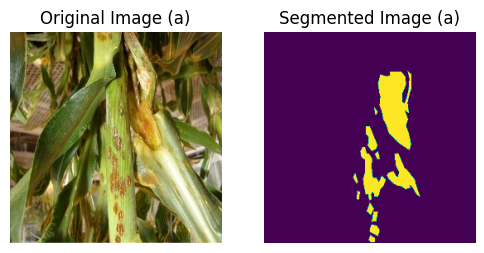

----------------------------------------------------


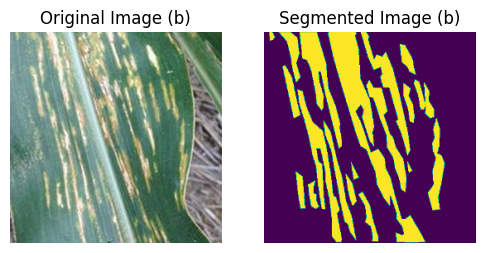

----------------------------------------------------


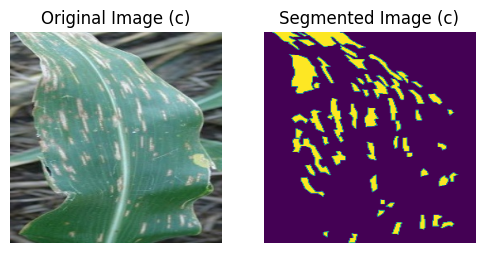

----------------------------------------------------


In [7]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

def show_images(loops=1, figsize=(8, 4)):
    mask_files = os.listdir(train_mask_dir)
    random.shuffle(mask_files)
    alphabet = 'abcdefghijklmnopqrstuvwxyz'
    for i in range(loops):
        mask_file = mask_files[i]
        img_name = os.path.splitext(mask_file)[0]
        img_path = os.path.join(train_image_dir, img_name + ".jpg")
        mask_path = os.path.join(train_mask_dir, mask_file)
        img = Image.open(img_path)
        mask = Image.open(mask_path)
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        axes[0].imshow(img)
        axes[0].set_title('Original Image ({})'.format(alphabet[i]))
        axes[0].axis('off')
        axes[1].imshow(mask)
        axes[1].set_title('Segmented Image ({})'.format(alphabet[i]))
        axes[1].axis('off')
        plt.show()
        print("----------------------------------------------------")

show_images(3, figsize=(6, 3))  # Adjust the figsize as needed


resizing images for train:

In [ ]:
seed = 42
np.random.seed = seed

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3



X_train = np.zeros((num_train_samples, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((num_train_samples, IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)


print('Resizing training images and masks')
for i in tqdm(range(num_train_samples), desc='Processing images'):
    img_path = os.path.join(train_image_dir, image_files[i])
    source_mask_file = os.path.splitext(image_files[i])[0] + ".png"
    mask_path = os.path.join(train_mask_dir, source_mask_file)

    img = Image.open(img_path)
    img = np.array(img)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[i] = img

    mask = Image.open(mask_path).convert('L')
    mask = np.array(mask)
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
    Y_train[i] = mask


X_test = np.zeros((num_validation_samples, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []

print('Resizing test images')
for i in tqdm(range(num_validation_samples), desc='Processing images'):
    img_path = os.path.join(test_image_dir, image_files[i])
    img = Image.open(img_path)
    img = np.array(img)
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[i] = img

Resizing training images and masks


Processing images: 100%|██████████| 2352/2352 [11:48<00:00,  3.32it/s]


Resizing test images


Processing images: 100%|██████████| 588/588 [02:13<00:00,  4.42it/s]


vizulizing the resized images:

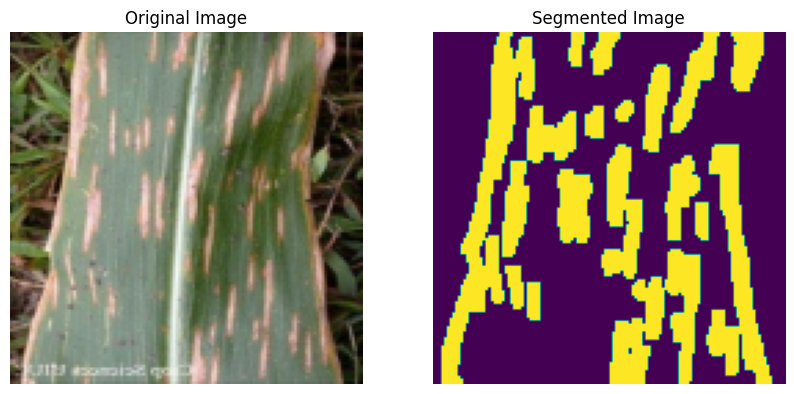

In [ ]:
image_x = 6

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the original image
axes[0].imshow(X_train[image_x])
axes[0].set_title('Original Image')
axes[0].axis('off')

# Display the segmented image
axes[1].imshow(np.squeeze(Y_train[image_x]))
axes[1].set_title('Segmented Image')
axes[1].axis('off')

plt.show()

building UNet model:

In [ ]:
#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 lambda (Lambda)             (None, 128, 128, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         448       ['lambda[0][0]']              
                                                                                                  
 dropout (Dropout)           (None, 128, 128, 16)         0         ['conv2d[0][0]']              
                                                                                              

train

In [ ]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('Leaf_segmentation.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

history = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
unetacc = history.history['accuracy'][-1]

Epoch 1/25
133/133 [==============================] - 382s 3s/step - loss: 0.4908 - accuracy: 0.7725 - val_loss: 0.4041 - val_accuracy: 0.7846
Epoch 2/25
133/133 [==============================] - 367s 3s/step - loss: 0.3944 - accuracy: 0.8183 - val_loss: 0.3962 - val_accuracy: 0.8227
Epoch 3/25
133/133 [==============================] - 367s 3s/step - loss: 0.3733 - accuracy: 0.8336 - val_loss: 0.3775 - val_accuracy: 0.8297
Epoch 4/25
122/133 [==========================>...] - ETA: 29s - loss: 0.3480 - accuracy: 0.8490

KeyboardInterrupt: 